In [1]:
import numpy as np
import pylab
import healpy as hp
import pysm3 
import pysm3.units as u
import matplotlib.pyplot as py
from astropy import units as u_sci
import cmbdb as cmb


In [2]:
from fgbuster.mixingmatrix import MixingMatrix
from fgbuster.component_model import CMB, Dust, Synchrotron
from fgbuster.separation_recipes import standardize_instrument, _intersect_mask,_get_prewhiten_factors,_A_evaluator,_get_alms,_format_alms,_r_to_c_alms

import fgbuster.algebra as alg
from fgbuster.observation_helpers import get_instrument,get_noise_realization,get_sky,get_observation
from fgbuster.cosmology import _get_Cl_noise
from fgbuster.separation_recipes import harmonic_comp_sep, basic_comp_sep

In [3]:
%config Completer.use_jedi = False

In [4]:
uK_RJ2uK_CMB = 1* u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(300.0 * u.GHz))
a = uK_RJ2uK_CMB
print(uK_RJ2uK_CMB)

6.983704969016967


In [5]:
def D_ell(C_ell):
    # Determine the length of the input power spectrum
    n_ell = len(C_ell)

    # Create an array of zeros to store the scale invariant power spectrum
    D_ell = np.zeros(n_ell)

    # Compute the scale invariant power spectrum using vectorized operations
    # Vectorized operations eliminate the need for a for loop, improving performance

    # Compute the product of each element with the next element using np.arange(n_ell) * (np.arange(n_ell) + 1)
    # Multiply the above result by C_ell to perform element-wise multiplication with the corresponding elements in C_ell
    # Divide the above result by np.pi to perform element-wise division by pi
    D_ell = np.arange(n_ell) * (np.arange(n_ell) + 1) * C_ell / np.pi

    # Return the computed scale invariant power spectrum
    return D_ell

In [6]:
amin2rad = np.pi/(60.*180.)

# Simulating Sky

In [7]:
NSIDE = 128
lmax = 3*NSIDE-1  # Maximum ell value based on the given NSIDE value
# lmax = 2*NSIDE
sky_d0s0 = get_sky(NSIDE, 'd0s0')  # Get the sky map using the specified NSIDE and sky type 'd0s0'

instrument = get_instrument('LiteBIRD')  # Get the instrument information for 'LiteBIRD'
freq_maps_d0s0 = get_observation(instrument, sky_d0s0)
# Obtain the frequency maps for the given instrument and sky map.
# freq_maps_d0s0 is a 3D array containing the observed maps for each frequency channel.

num_freq, ncomp, npix = freq_maps_d0s0.shape
# Retrieve the dimensions of the freq_maps_d0s0 array.
# - num_freq represents the number of frequency channels.
# - ncomp represents the number of components in the observed map.
# - npix represents the number of pixels in the observed map.

/home/julientang2001/fgbuster/fgbuster/observation_helpers.py:97: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  return df.dropna(1, 'all')


In [8]:
print(instrument.fwhm)

0     70.5
1     58.5
2     51.1
3     47.1
4     43.8
5     41.5
6     37.8
7     33.6
8     30.8
9     28.9
10    28.6
11    24.7
12    22.5
13    20.9
14    17.9
Name: fwhm, dtype: float64


In [9]:
instrument.fwhm = np.zeros(15)
print(instrument.fwhm)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
Name: fwhm, dtype: float64


In [10]:
cl_CMB_th = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_lensed_scalar.fits")

cl_CMB_crop_th = cl_CMB_th[:,:lmax+1]

np.random.seed(0)
map_CMB = hp.synfast(cl_CMB_th,nside=NSIDE,new = True)


print(map_CMB.shape)
cl_CMB6 = hp.anafast(map_CMB,lmax=lmax,alm = False)
cl_CMB = cl_CMB6[:4]
print(cl_CMB.shape)

(3, 196608)
(4, 384)


In [11]:
freq_maps_simple_noiseless1 = np.array([np.add(map_CMB,map_d0s0) for map_d0s0 in freq_maps_d0s0])
freq_maps_simple_noiseless2 = map_CMB+freq_maps_d0s0


In [12]:
np.where(freq_maps_simple_noiseless1-freq_maps_simple_noiseless2!=0)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [13]:
beam_array = np.array([hp.gauss_beam(f*amin2rad,lmax = lmax, pol=True) for f in instrument.fwhm])
print(beam_array.shape)

(15, 384, 4)


In [14]:
inv_beam_arr = 1/beam_array
fwhm_common = 80*amin2rad
beam_common = hp.gauss_beam(fwhm_common,lmax = lmax, pol = True)
b_c = np.array([beam_common*beam_inv for beam_inv in inv_beam_arr])
print(b_c.shape)

(15, 384, 4)


## Beam (check with hp.smoothing)

In [15]:
map_CMB_smooth = np.array([hp.smoothing(map_CMB[j,:],fwhm = fwhm_common,pol=True) for j in range(0,ncomp)])
print(map_CMB_smooth.shape)

map_CMB_smooth_QU =map_CMB_smooth[1:3]
print(map_CMB_smooth_QU.shape)

cl_CMB_smooth = hp.anafast(map_CMB_smooth,lmax=lmax,alm=False)


(3, 196608)
(2, 196608)


In [16]:
alm_CMB_smooth = hp.map2alm(map_CMB_smooth,lmax)

#### Beaming maps
We want to compute $(B \ast As)_p$.
We start with convolution of the noiseless signal.

In [18]:
BAS_p_nl_smooth = np.array([np.array([hp.smoothing(freq_maps_simple_noiseless2[i,j],fwhm = instrument.fwhm[i] ,pol=True) for j in range(0,ncomp) ]) for i in range(0,num_freq)])
print(BAS_p_nl_smooth.shape)


(15, 3, 196608)


In [19]:
print(freq_maps_simple_noiseless1.shape)

(15, 3, 196608)


In [20]:
AS_p_inv = np.array([np.array([hp.smoothing(BAS_p_nl_smooth[i,j],beam_window=inv_beam_arr[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])

AS_p_ren = np.array([np.array([hp.smoothing(BAS_p_nl_smooth[i,j],beam_window=b_c[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])

In [21]:
print(beam_common.shape)

(384, 4)


In [22]:
# AS_p_inv = freq_maps_simple_noiseless2
# AS_p_ren = np.array([np.array([hp.smoothing(freq_maps_simple_noiseless2[i,j],beam_window=beam_common[j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])

In [23]:
print(AS_p_inv.shape)

(15, 3, 196608)


In [24]:
np.linalg.norm(AS_p_inv - freq_maps_simple_noiseless1) / np.linalg.norm(freq_maps_simple_noiseless1)

0.07393989139509166

## Component separation

In [25]:
components = [CMB(), Dust(353.), Synchrotron(23.)]

In [26]:
# The starting point of the fit is the pysm default value, so let's shift it
components[1].defaults = [1.54, 20.]
components[2].defaults = [-3.0]

In [27]:
result_basic_inv= basic_comp_sep(components, instrument, AS_p_inv[:,1:3,:], # verbose output                        
                       )  ## noiseless
result_basic_ren = basic_comp_sep(components, instrument,AS_p_ren[:,1:3,:] # verbose output             
                               )


In [28]:
print(result_basic_inv.s.shape)
result_harmo_inv= harmonic_comp_sep(components, instrument, AS_p_inv,nside=NSIDE,lmax=lmax # verbose output                        
                       )  ## noiseless
result_harmo_ren = harmonic_comp_sep(components, instrument, AS_p_ren,nside=NSIDE,lmax=lmax  # verbose output             
                               )
print(result_harmo_inv.s.shape)


(3, 2, 196608)
Computing alms


/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/algebra.py:1079: RuntimeWarning: invalid value encountered in divide
  res.chi_dB.append(np.sum(res.chi * As_dB_i, -1)


Computing alms
(3, 2, 73920)


/home/julientang2001/fgbuster/fgbuster/algebra.py:1079: RuntimeWarning: invalid value encountered in divide
  res.chi_dB.append(np.sum(res.chi * As_dB_i, -1)


In [29]:
inputs = [sky_d0s0.components[0].mbb_index,
          sky_d0s0.components[0].mbb_temperature.value,
          sky_d0s0.components[1].pl_index]
print('Basic + deconvolved'+'\n')
print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_basic_inv.params, result_basic_inv.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))
print('\n'+'Basic + reconvolved'+'\n')
print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_basic_ren.params, result_basic_ren.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))

print('\n'+'Harmonic + deconvolved'+'\n')
print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_harmo_inv.params, result_harmo_inv.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))
print('\n'+'Harmonic + reconvolved'+'\n')
print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_harmo_ren.params, result_harmo_ren.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))


Basic + deconvolved

                    	Estimated	Input
Dust.beta_d         	1.540000	1.540000
Dust.temp           	20.000000	20.000000
Synchrotron.beta_pl 	-3.000000	-3.000000

Basic + reconvolved

                    	Estimated	Input
Dust.beta_d         	1.540000	1.540000
Dust.temp           	20.000000	20.000000
Synchrotron.beta_pl 	-3.000000	-3.000000

Harmonic + deconvolved

                    	Estimated	Input
Dust.beta_d         	1.540000	1.540000
Dust.temp           	20.000000	20.000000
Synchrotron.beta_pl 	-3.000000	-3.000000

Harmonic + reconvolved

                    	Estimated	Input
Dust.beta_d         	1.540000	1.540000
Dust.temp           	19.999999	20.000000
Synchrotron.beta_pl 	-2.999998	-3.000000


In [30]:
print(AS_p_inv-freq_maps_simple_noiseless2)

[[[-2.21056095e+00  1.79604207e+00  2.24111358e+00 ...  1.99971498e+00
    1.65181632e+00 -9.58358447e-02]
  [ 9.22239660e-01 -7.81875184e-01  6.92978829e-01 ... -4.96499702e-01
   -1.74445333e-01  2.98188349e-01]
  [ 2.93649907e-01 -1.85649907e-01  1.84646720e-01 ...  1.03481883e+00
   -9.84580582e-01  1.65305767e+00]]

 [[-2.65646254e+00  2.08142928e+00  2.82709736e+00 ...  2.13941470e+00
    1.90492876e+00 -4.47555945e-01]
  [ 9.32789721e-01 -7.38675841e-01  6.83980893e-01 ... -4.77009482e-01
   -1.82553735e-01  2.53213126e-01]
  [ 2.64319586e-01 -1.71225880e-01  1.96705776e-01 ...  9.42554543e-01
   -8.85339093e-01  1.54742313e+00]]

 [[-3.22699814e+00  2.48390687e+00  3.43111269e+00 ...  2.24553048e+00
    2.08782294e+00 -8.34255989e-01]
  [ 9.36238602e-01 -7.16766031e-01  6.78517012e-01 ... -4.67927697e-01
   -1.87005365e-01  2.34506340e-01]
  [ 2.53672677e-01 -1.65497156e-01  2.04137876e-01 ...  8.99533950e-01
   -8.39484942e-01  1.49808226e+00]]

 ...

 [[-9.84318934e+01  7.294

In [31]:
np.linalg.norm(AS_p_inv - freq_maps_simple_noiseless1) / np.linalg.norm(freq_maps_simple_noiseless2)

0.07393989139509166

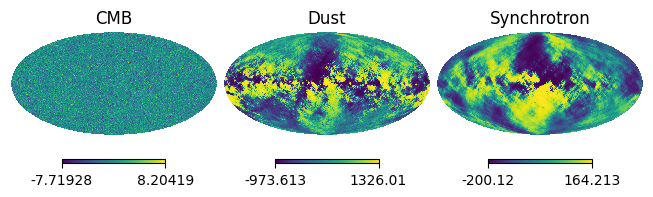

In [32]:
hp.mollview(result_basic_inv.s[0,1], title='CMB', sub=(1,3,1))
hp.mollview(result_basic_inv.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(result_basic_inv.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))


In [33]:
# hp.mollview(result_beam_smooth.s[0,1], title='CMB', sub=(1,3,1))
# hp.mollview(result_beam_smooth.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
# hp.mollview(result_beam_smooth.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))

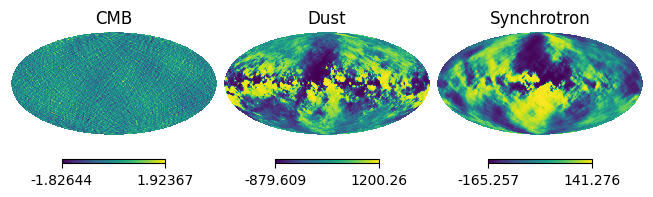

In [34]:
hp.mollview(result_basic_ren.s[0,1], title='CMB', sub=(1,3,1))
hp.mollview(result_basic_ren.s[1,1], title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(result_basic_ren.s[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))

Harmonic comp sep : from $a_{\ell m}$ to map

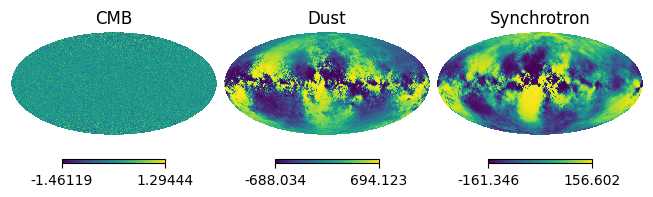

In [35]:
hp.mollview(hp.alm2map(result_harmo_inv.s[0,1],NSIDE,lmax), title='CMB', sub=(1,3,1))
hp.mollview(hp.alm2map(result_harmo_inv.s[1,1],NSIDE,lmax), title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(hp.alm2map(result_harmo_inv.s[2,1],NSIDE,lmax), title='Synchrotron', norm='hist', sub=(1,3,3))

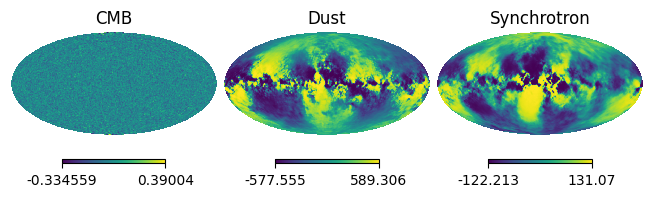

In [36]:
hp.mollview(hp.alm2map(result_harmo_ren.s[0,1],NSIDE,lmax), title='CMB', sub=(1,3,1))
hp.mollview(hp.alm2map(result_harmo_ren.s[1,1],NSIDE,lmax), title='Dust', norm='hist', sub=(1,3,2))
hp.mollview(hp.alm2map(result_harmo_ren.s[2,1],NSIDE,lmax), title='Synchrotron', norm='hist', sub=(1,3,3))


# Retrieved Power spectrum

# Residuals

For harmonic comp sep

In [37]:
alm_CMB = hp.map2alm(map_CMB,lmax)
alm_CMB_smooth = hp.map2alm(map_CMB_smooth,lmax)

In [38]:
res_CMB_alm_inv = result_harmo_inv.s[0,0:2]-alm_CMB[1:3]
res_CMB_alm_ren = result_harmo_ren.s[0,0:2]-alm_CMB_smooth[1:3]

In [39]:
print(map_CMB.shape)

(3, 196608)


Basic component separation

In [40]:
res_CMB_map_inv = result_basic_inv.s[0]-map_CMB[1:3]
res_CMB_map_ren = result_basic_ren.s[0]-map_CMB[1:3]

In [41]:
res_CMB_TEB_inv = np.zeros((3,npix),dtype=complex)
res_CMB_TEB_inv[1:3] = res_CMB_map_inv
print(res_CMB_TEB_inv.shape)

(3, 196608)


In [42]:
res_CMB_TEB_ren = np.zeros((3,npix),dtype=complex)
res_CMB_TEB_ren[1:3] = res_CMB_map_ren
print(res_CMB_TEB_ren.shape)

(3, 196608)


In [43]:
C_l_res_basic_inv =hp.anafast(res_CMB_TEB_inv,alm=False,pol=True)
C_l_res_basic_ren =hp.anafast(res_CMB_TEB_ren,alm=False,pol=True)
print(C_l_res_basic_inv.shape)

/home/julientang2001/.conda/envs/FGBuster_JT/lib/python3.11/site-packages/healpy/sphtfunc.py:274: ComplexWarning: Casting complex values to real discards the imaginary part
  alms = _sphtools.map2alm(


(6, 384)


In [44]:
C_l_res_harmo_inv=hp.alm2cl(res_CMB_alm_inv,lmax=lmax)
C_l_res_harmo_ren=hp.alm2cl(res_CMB_alm_ren,lmax=lmax)

# Retrieved CMB power spectra

In [45]:
ret_CMB_TEB_inv = np.zeros((3,npix),dtype=complex)
ret_CMB_TEB_inv[1:3] = result_basic_inv.s[0]
print(ret_CMB_TEB_inv.shape)

(3, 196608)


In [46]:
ret_CMB_TEB_ren = np.zeros((3,npix),dtype=complex)
ret_CMB_TEB_ren[1:3] = result_basic_ren.s[0]
print(ret_CMB_TEB_ren.shape)

(3, 196608)


In [47]:
C_l_ret_basic_inv =hp.anafast(ret_CMB_TEB_inv,alm=False,pol=True)
C_l_ret_basic_ren =hp.anafast(ret_CMB_TEB_ren,alm=False,pol=True)
print(C_l_ret_basic_inv.shape)

(6, 384)


In [48]:
C_l_ret_harmo_inv=hp.alm2cl(result_harmo_inv.s[0],lmax=lmax)
C_l_ret_harmo_ren=hp.alm2cl(result_harmo_ren.s[0],lmax=lmax)

# + Gravitational waves

In [49]:
cl_GW = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits")
print(cl_GW.shape)
cl_GW_crop = cl_GW[:,:lmax+1]
print(cl_GW_crop.shape)

map_CMB_GW = hp.synfast(cl_GW,nside=NSIDE)

(4, 4101)
(4, 384)


In [50]:
cl_tot_th = np.add(0.001*cl_GW_crop,cl_CMB)

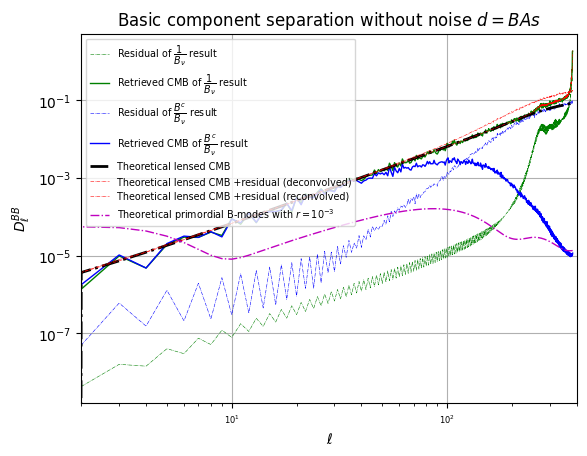

In [54]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)
ax1.plot(l_arr,D_ell(C_l_res_basic_inv[2]),'g-.',linewidth =.4,label = 'Residual of $\dfrac{1}{B_{\\nu}}$ result')
ax1.plot(l_arr,D_ell(C_l_ret_basic_inv[2]),'g-',linewidth = 1,label = 'Retrieved CMB of $\dfrac{1}{B_{\\nu}}$ result')
ax1.plot(l_arr,D_ell(C_l_res_basic_ren[2]),'b-.',linewidth =.4,label = 'Residual of $\dfrac{B^c}{B_{\\nu}}$ result')
ax1.plot(l_arr,D_ell(C_l_ret_basic_ren[2]),'b-',linewidth = 1,label = 'Retrieved CMB of $\dfrac{B^c}{B_{\\nu}}$ result')
py.title('Basic component separation without noise $d=BAs$')

ax1.plot(l_arr,l_arr*(l_arr+1)*cl_CMB_crop_th[2]/np.pi,'k-.',linewidth =2,label = "Theoretical lensed CMB ")
ax1.plot(l_arr,D_ell(C_l_res_basic_inv[2]+cl_CMB_crop_th[2]),'r-.',linewidth =0.4,label = "Theoretical lensed CMB +residual (deconvolved)")
ax1.plot(l_arr,D_ell(C_l_res_basic_ren[2]+cl_CMB_crop_th[2]),'r-.',linewidth =0.4,label = "Theoretical lensed CMB +residual (reconvolved)")



ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")


handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2 #,right =2*NSIDE
)

py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")


py.ylabel('$D_{\ell}^{BB}$')  
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

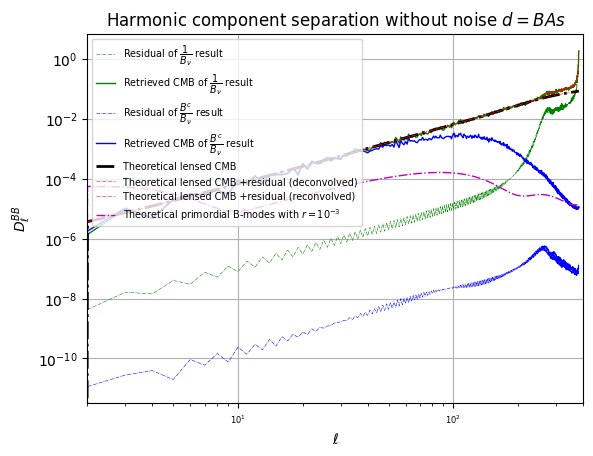

In [55]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)
ax1.plot(l_arr,D_ell(C_l_res_harmo_inv[1]),'g-.',linewidth =.4,label = 'Residual of $\dfrac{1}{B_{\\nu}}$ result')
ax1.plot(l_arr,D_ell(C_l_ret_harmo_inv[1]),'g-',linewidth = 1,label = 'Retrieved CMB of $\dfrac{1}{B_{\\nu}}$ result')
ax1.plot(l_arr,D_ell(C_l_res_harmo_ren[1]),'b-.',linewidth =.4,label = 'Residual of $\dfrac{B^c}{B_{\\nu}}$ result')
ax1.plot(l_arr,D_ell(C_l_ret_harmo_ren[1]),'b-',linewidth = 1,label = 'Retrieved CMB of $\dfrac{B^c}{B_{\\nu}}$ result')
py.title('Harmonic component separation without noise $d=BAs$')

ax1.plot(l_arr,l_arr*(l_arr+1)*cl_CMB_crop_th[2]/np.pi,'k-.',linewidth =2,label = "Theoretical lensed CMB ")
ax1.plot(l_arr,D_ell(C_l_res_harmo_inv[1]+cl_CMB_crop_th[2]),'r-.',linewidth =0.4,label = "Theoretical lensed CMB +residual (deconvolved)")
ax1.plot(l_arr,D_ell(C_l_res_harmo_ren[1]+cl_CMB_crop_th[2]),'r-.',linewidth =0.4,label = "Theoretical lensed CMB +residual (reconvolved)")


ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")


handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2 #,right =2*NSIDE
)

py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")


py.ylabel('$D_{\ell}^{BB}$')  
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

### Cosmological parameters

In [53]:
def cosmo_likelihood(r,C_l_obs,noise):
    if len(C_l_obs)!=lmax+1 or len(noise)!=lmax+1:
        raise Warning("Arrays should be of size "+str(lmax))
    
    C_lth =r*cl_GW_crop[2]+cl_CMB_crop_th[2]+noise
    sig = 0
    for l in range(2,lmax):
        sig+=(2*l+1)*(np.log(C_lth[l])+C_l_obs[l]/C_lth[l])
    return (sig)
